# Quantum state tomography (QST) with Gradient descent (GD) 

## Using the method of Cholesky triangular

## Note 1:

For the GD methods it is necesary the library Jax (https://github.com/google/jax). Also QuTip is a very important library.

In [2]:
# To call the libraries for the GD-QST
import sys
sys.path.insert(0, '..')
# You have to change the path of the library 
import os


from qutip import * 
from itertools import *
import numpy as np
import matplotlib.pyplot as plt 
import qutip as qtp
#from qutip import basis, tensor

# Libraries for the different methods of doing QST with GD
from qst_tec.gdchol_triangular import gd_chol_triangular, cholesky_f, rho_cons

import jax
import jax.numpy as jnp
import jax.numpy.linalg  as nlg
from jax import grad
from jax import jit
from jax.example_libraries import optimizers
from jax import config
config.update("jax_enable_x64", True) # We want float64 for better precision
import optax

from tqdm.auto import tqdm   # For the progressbars
import time

### First we will define the number of qubits and the measurement operators. We will use the Pauli matrices.

In [3]:
number_qubits: int = 3
dimension: int = 2**number_qubits
HS: int = dimension


# Creating the Measurement operators (Pauli matrices)

pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
pauli_sys = [tensor(*op) for op in product(pauli, repeat=number_qubits)] # using itertools

Measu_ope = [Qobj(pauli_sys[i], dims=([[2**number_qubits], [2**number_qubits]])) for i in range(len(pauli_sys))]

print(Measu_ope[1:3])

#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy 
# type to a jax type (jax.np), that because of the jax grad 

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]], Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]]]


## The ansatz

We need to create an ansatz that is a lower triangular

$$T_g =  \begin{pmatrix}
a_1 & 0 & 0 \\
b_1 & b_2 & 0 \\
c_1 & c_2 & c_3 
\end{pmatrix} $$

In [4]:
def ansatz(kn: int):
    """
    Creates the proper ansatz structure for the different GD methods
    
    Args: 
        kn (int) : rank number, but for the case of the triangular cholesky the value is
                    for the dimensions of the arrays
    
    Output:
        T_triangular : Ansatz GD-Cholesky triangular
        
    """
    
    # T_rank  = arbitrary r x p matrix ansatz for Cholesky
    real_part = np.random.rand(kn, dimension)  # Random numbers from a uniform distribution over [0, 1)
    imaginary_part = np.random.rand(kn, dimension)  # Same for the imaginary part
    guess = real_part + 1j * imaginary_part
    T_rank = jnp.asarray(guess)

    # T_triangular Lower traingular matrix ansatz for Cholesky
    T_triangular = jnp.asarray(rho_cons(np.random.rand(dimension, dimension) + 1j*np.random.rand(dimension, dimension)))

    return T_triangular


Visualizing the ansatz (optional)

In [5]:
def print_matrix(A):
    # This function is just to print the ansatz matrix, it is not necessary for the QST
    for row in A:
        print(' '.join(map(str, row))) # Convert each element to a string and join with spaces

print_matrix(ansatz(HS))

(0.22711067960049336+0j) 0j 0j 0j 0j 0j 0j 0j
(0.6319098828658021+0.3983116828697355j) (0.5842609179148937+0j) 0j 0j 0j 0j 0j 0j
(0.8905106629624898+0.12316162085185667j) (0.11009357844695988+0.40570313481248943j) (0.6127582795862877+0j) 0j 0j 0j 0j 0j
(0.7648381925671494+0.18910650052979106j) (0.6058941504881276+0.20647687672740878j) (0.2637810499523757+0.8704993266950796j) (0.42616853880342975+0j) 0j 0j 0j 0j
(0.924910378717767+0.36919141140159273j) (0.011350102853933564+0.9520883715271177j) (0.7438953479023397+0.592398198592887j) (0.2862976011543491+0.7314755062970872j) (0.9534902228469315+0j) 0j 0j 0j
(0.6430718678936995+0.7442195155441476j) (0.3695329978500824+0.2576817835473988j) (0.6562401283461151+0.12184360089539126j) (0.21995168457377756+0.09909669209779237j) (0.4039874769331613+0.652099291118839j) (0.5626944506428013+0j) 0j 0j
(0.4437656256644834+0.9776476980596143j) (0.28386111103286493+0.31179480547825844j) (0.526373779110915+0.37934908829767544j) (0.17958553902131513+0.91

## Implementing the GD Cholesky triangular

In [6]:
fid_list_chol_triangular, time_list_chol_triangular = [], []

# defining the number of iterations for the GD method
max_itera: int = 500
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 
# in this case we are taking the 50% of the measurement operators

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = rand_dm(2**number_qubits)
data = qtp.expect(Measu_ope,rho_or)

# calling the ansatz
rank: int = 2**number_qubits # maximum rank is 2**N
T_triangular = ansatz(rank)

# Applying the GD triangular cholesky method
rho_gd_chol_triangular, f_gd_chol_triangular, t_gd_chol_triangular, _ = gd_chol_triangular(data, rho_or, ops_jnp, T_triangular, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
fid_list_chol_triangular.append(f_gd_chol_triangular)
time_list_chol_triangular.append(t_gd_chol_triangular)

Fidelity GD-chol-triangular 0.9876: 100%|██████████| 500/500 [00:02<00:00, 241.71it/s]


## Plotting the fidelities 

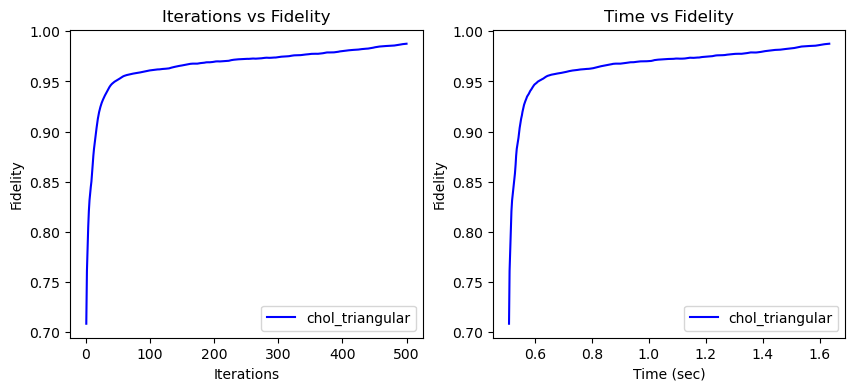

In [7]:
# Transforming to a np arrays and in the case of have more than 1 run the average
fid_list_chol_triangular = np.array(fid_list_chol_triangular)
mean_fid_chol_triangular = np.mean(fid_list_chol_triangular, axis=0)
time_list_chol_triangular = np.array(time_list_chol_triangular)
mean_time_chol_triangular = np.mean(time_list_chol_triangular, axis=0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_chol_triangular)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_chol_triangular, color='blue',label="chol_triangular")


ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)

ax2.plot(mean_time_chol_triangular, mean_fid_chol_triangular, color='blue',label="chol_triangular")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()

In [8]:
print('max fidelity (chol_triangular) and time in seconds:', [np.max(f_gd_chol_triangular), mean_time_chol_triangular[np.argmax(mean_fid_chol_triangular)]])


max fidelity (chol_triangular) and time in seconds: [0.9875790827550379, 1.633939266204834]


## GHZ state
Now let's reconstruct a GHZ state
$$ \frac{|000\rangle + |111\rangle}{\sqrt{2}}$$

In [9]:
# Define the basis states |0> and |1> for a single qubit
zero = qtp.basis(2, 0)  # |0>
one = qtp.basis(2, 1)   # |1>

# Construct the |000> and |111> states for 3 qubits
state_000 = qtp.tensor(zero, zero, zero)  # |000>
state_111 = qtp.tensor(one, one, one)     # |111>

# Create the GHZ state: (|000> + |111>) / sqrt(2)
ghz_state = (state_000 + state_111).unit()
ghz_state = qtp.Qobj(ghz_state.full(), dims=[[8], [1]])  # Reshape the GHZ state to have dimensions [8]
# This reshape is necessary for the function qtp.expect. It will depend of the version of QuTip
 
print(ghz_state)

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket'
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


In [10]:
fid_list_chol_triangular, time_list_chol_triangular = [], []

# defining the number of iterations for the GD method
max_itera: int = 500
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 
# in this case we are taking the 50% of the measurement operators

rho_or = ghz_state
data = qtp.expect(Measu_ope,rho_or)

# calling the ansatz
rank: int = 1 # maximum rank is 2**N
T_triangular = ansatz(rank)

# Applying the GD triangular cholesky method
rho_gd_chol_triangular, f_gd_chol_triangular, t_gd_chol_triangular, _ = gd_chol_triangular(data, rho_or, ops_jnp, T_triangular, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
fid_list_chol_triangular.append(f_gd_chol_triangular)
time_list_chol_triangular.append(t_gd_chol_triangular)

Fidelity GD-chol-triangular 0.9998: 100%|██████████| 500/500 [00:01<00:00, 316.49it/s]


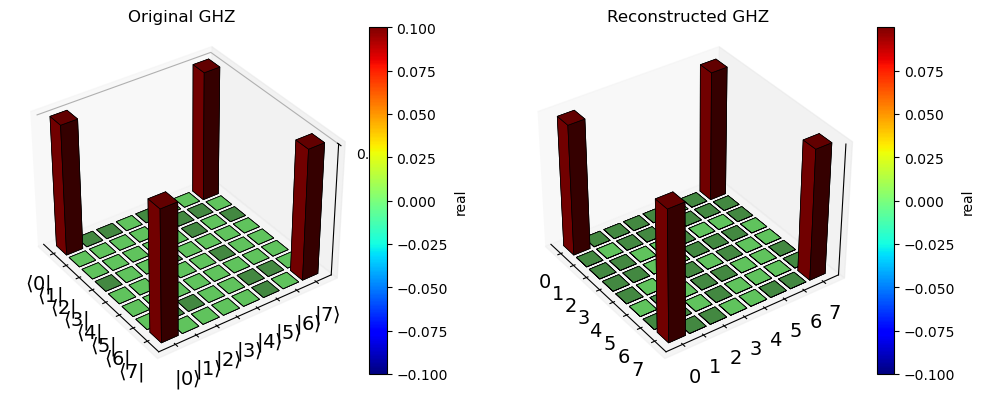

In [11]:
rho_ghz = tensor(ghz_state, ghz_state.dag())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": "3d"})

# Plot the first matrix histogram
matrix_histogram(rho_ghz, ax=axes[0])
axes[0].set_title("Original GHZ")

# Plot the second matrix histogram
matrix_histogram(rho_gd_chol_triangular, ax=axes[1])
axes[1].set_title("Reconstructed GHZ")

# Show the plots
plt.show()

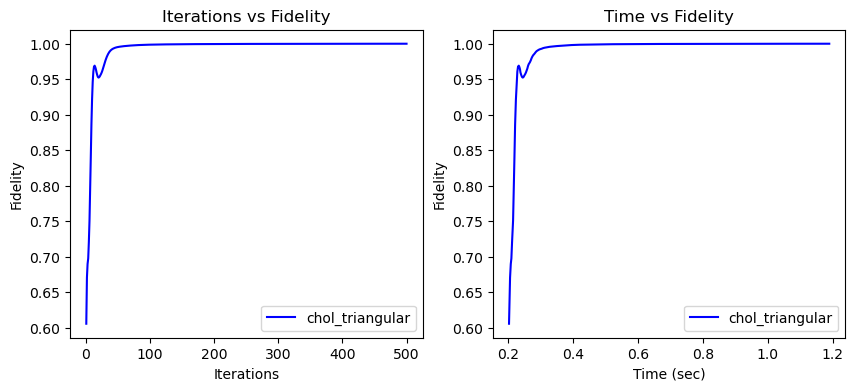

In [12]:
# Transforming to a np arrays and in the case of have more than 1 run the average
fid_list_chol_triangular = np.array(fid_list_chol_triangular)
mean_fid_chol_triangular = np.mean(fid_list_chol_triangular, axis=0)
time_list_chol_triangular = np.array(time_list_chol_triangular)
mean_time_chol_triangular = np.mean(time_list_chol_triangular, axis=0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_chol_triangular)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_chol_triangular, color='blue',label="chol_triangular")


ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)

ax2.plot(mean_time_chol_triangular, mean_fid_chol_triangular, color='blue',label="chol_triangular")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()